# Data Profiling: Public employment and representation

Source of data: https://data-explorer.oecd.org/vis?tm=urban%20population&pg=0&snb=144&vw=tb&df%5Bds%5D=dsDisseminateFinalDMZ&df%5Bid%5D=DSD_REG_LAB%40DF_TYPE_RURB&df%5Bag%5D=OECD.CFE.EDS&df%5Bvs%5D=2.0&dq=A..AUS%2BAUT..EMP_RATIO.Y15T64._T.&lom=LASTNPERIODS&lo=5&to%5BTIME_PERIOD%5D=false

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from ydata_profiling import ProfileReport

In [2]:
raw_data_path = "../data/10_public_employment_and_representation/raw/OECD.GOV.GIP,DSD_GOV@DF_GOV_EMPPS_REP_2023,+all.csv"
output_path = "../data/10_public_employment_and_representation/preprocessed/PUBLIC_EMPLOYMENT.csv"

report_path = "reports/10_data_profile_public_employment_and_representation.html"

## Load and inspect data

In [3]:
df = pd.read_csv(raw_data_path)
df.head(2)

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,FREQ,Frequency of observation,REF_AREA,Reference area,MEASURE,Measure,...,OBS_VALUE,Observation value,OBS_STATUS,Observation status,UNIT_MULT,Unit multiplier,PRICE_BASE,Price base,BASE_PER,Base period
0,DATAFLOW,OECD.GOV.GIP:DSD_GOV@DF_GOV_EMPPS_REP_2023(1.0),Public employment and representation - Governm...,I,A,Annual,AUT,Austria,EMPG,Employment in government,...,16.92,NaN,A,Normal value,0,Units,_Z,Not applicable,NaN,NaN
1,DATAFLOW,OECD.GOV.GIP:DSD_GOV@DF_GOV_EMPPS_REP_2023(1.0),Public employment and representation - Governm...,I,A,Annual,BEL,Belgium,EMPG,Employment in government,...,18.49,NaN,A,Normal value,0,Units,_Z,Not applicable,NaN,NaN


### Shape and date types

In [4]:
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")

Dataset has 2387 rows and 30 columns


In [5]:
print(dict(df.dtypes))

{'STRUCTURE': dtype('O'), 'STRUCTURE_ID': dtype('O'), 'STRUCTURE_NAME': dtype('O'), 'ACTION': dtype('O'), 'FREQ': dtype('O'), 'Frequency of observation': dtype('O'), 'REF_AREA': dtype('O'), 'Reference area': dtype('O'), 'MEASURE': dtype('O'), 'Measure': dtype('O'), 'UNIT_MEASURE': dtype('O'), 'Unit of measure': dtype('O'), 'SECTOR': dtype('O'), 'Institutional sector': dtype('O'), 'EDITION': dtype('int64'), 'Edition': dtype('int64'), 'CATEGORY': dtype('O'), 'Category': dtype('O'), 'TIME_PERIOD': dtype('int64'), 'Time period': dtype('float64'), 'OBS_VALUE': dtype('float64'), 'Observation value': dtype('float64'), 'OBS_STATUS': dtype('O'), 'Observation status': dtype('O'), 'UNIT_MULT': dtype('int64'), 'Unit multiplier': dtype('O'), 'PRICE_BASE': dtype('O'), 'Price base': dtype('O'), 'BASE_PER': dtype('float64'), 'Base period': dtype('float64')}


### Missing values

In [6]:
df.isna().sum()[df.isna().sum() > 0] * 100 / df.shape[0]

Time period          100.0
Observation value    100.0
BASE_PER             100.0
Base period          100.0
dtype: float64

In [7]:
# Drop entirely null columns
df.drop(columns=["Time period", "Observation value", "BASE_PER", "Base period"], inplace=True)

EDITION


,count,mean,std,min,25%,50%,75%,max
EDITION,2387.0,2023.0,0.0,2023.0,2023.0,2023.0,2023.0,2023.0


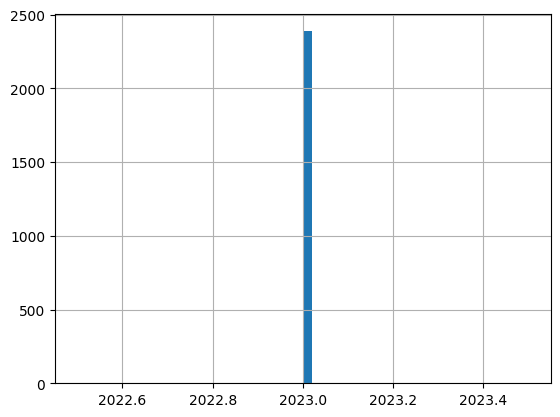

Edition


,count,mean,std,min,25%,50%,75%,max
Edition,2387.0,2023.0,0.0,2023.0,2023.0,2023.0,2023.0,2023.0


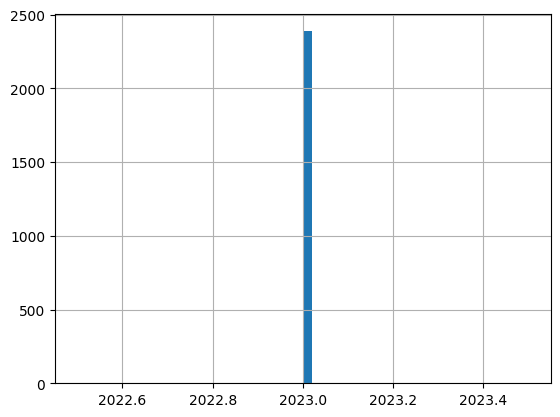

UNIT_MULT


,count,mean,std,min,25%,50%,75%,max
UNIT_MULT,2387.0,0.648513,1.235155,0.0,0.0,0.0,0.0,3.0


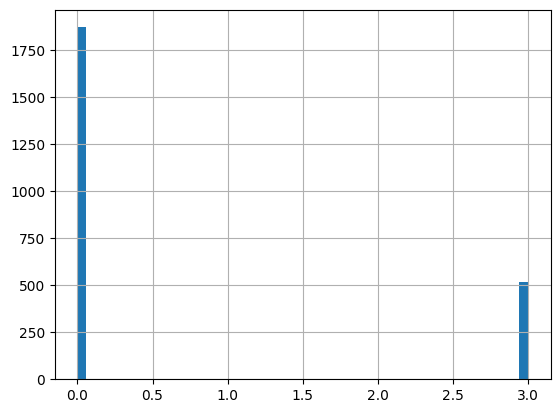

OBS_VALUE


,count,mean,std,min,25%,50%,75%,max
OBS_VALUE,2387.0,506.435417,1991.515694,0.0,21.35,37.3,58.0,23172.0


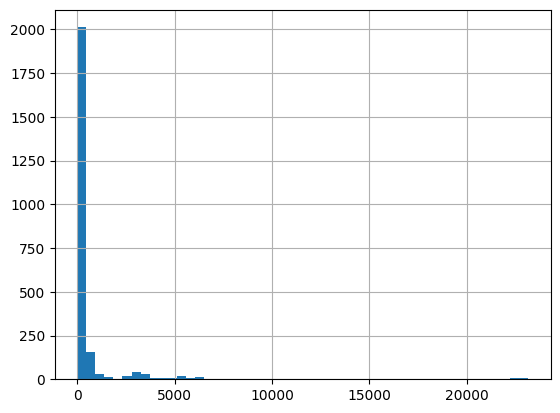

TIME_PERIOD


,count,mean,std,min,25%,50%,75%,max
TIME_PERIOD,2387.0,2015.549225,4.934736,2002.0,2012.0,2016.0,2020.0,2023.0


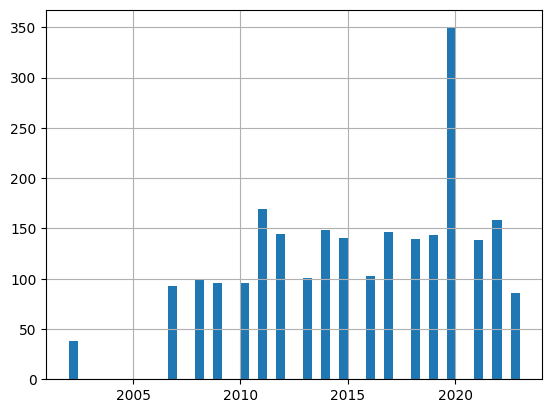

In [9]:
# Look also for zeros
# For some columns, values that are exactly zero may be unlikely, so they are most likely in fact missing data
num_cols = ["EDITION", "Edition", "UNIT_MULT", "OBS_VALUE", "TIME_PERIOD"]

for n in num_cols:
    print(n)
    display(df[[n]].describe().T)
    df[n].hist(bins=50)
    plt.show()

In [11]:
# Drop columns with unique values
df.drop(columns=["Edition", "EDITION"], inplace=True)

In [14]:
# Create a copy of the target without zeros
target = "public_employment"

df[target] = df["OBS_VALUE"]
df.loc[df[target] == 0, target] = pd.NA

In [17]:
a = df.isna().sum()[df.isna().sum() > 0]
print(a)
print(a * 100 / df.shape[0])

public_employment    2
dtype: int64
public_employment    0.083787
dtype: float64


### Numerical features

In [18]:
num_cols = ["UNIT_MULT", "OBS_VALUE", "TIME_PERIOD", target]
df[num_cols].describe()

,UNIT_MULT,OBS_VALUE,TIME_PERIOD,public_employment
count,2387.000000,2387.000000,2387.000000,2385.000000
mean,0.648513,506.435417,2015.549225,506.860101
std,1.235155,1991.515694,4.934736,1992.296842
min,0.000000,0.000000,2002.000000,1.200000
25%,0.000000,21.350000,2012.000000,21.400000
50%,0.000000,37.300000,2016.000000,37.310000
75%,0.000000,58.000000,2020.000000,58.000000
max,3.000000,23172.000000,2023.000000,23172.000000


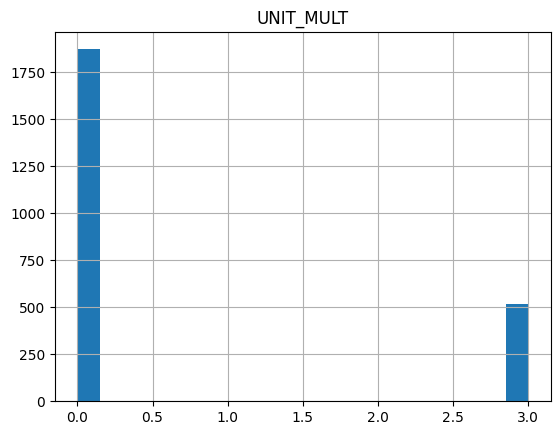

,count,mean,std,min,25%,50%,75%,max
UNIT_MULT,2387.0,0.648513,1.235155,0.0,0.0,0.0,0.0,3.0


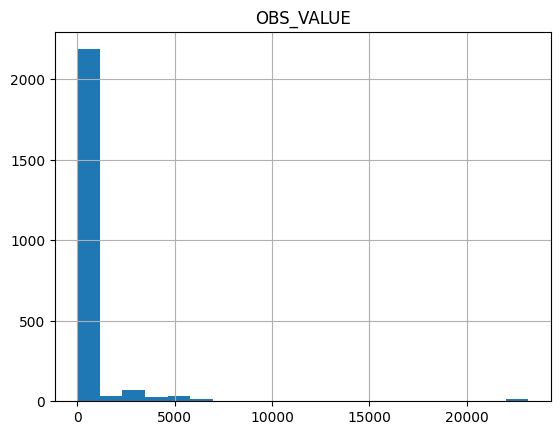

,count,mean,std,min,25%,50%,75%,max
OBS_VALUE,2387.0,506.435417,1991.515694,0.0,21.35,37.3,58.0,23172.0


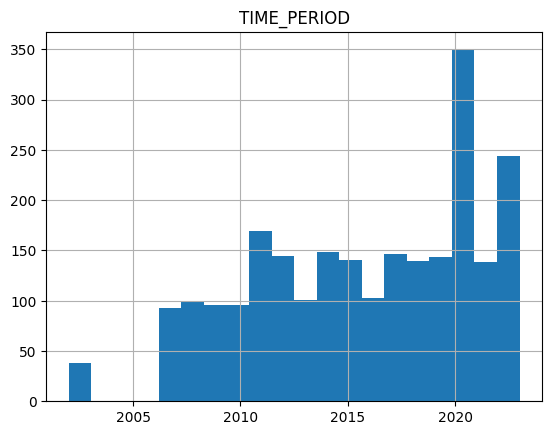

,count,mean,std,min,25%,50%,75%,max
TIME_PERIOD,2387.0,2015.549225,4.934736,2002.0,2012.0,2016.0,2020.0,2023.0


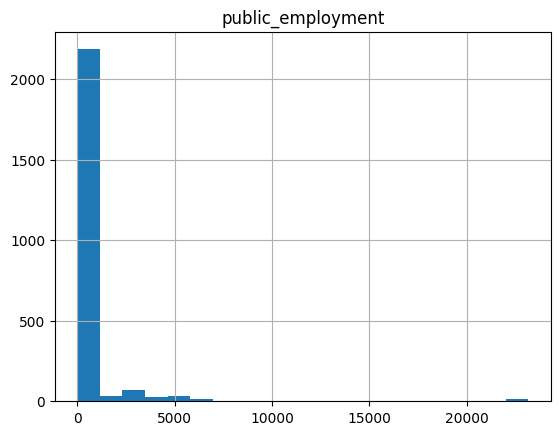

,count,mean,std,min,25%,50%,75%,max
public_employment,2385.0,506.860101,1992.296842,1.2,21.4,37.31,58.0,23172.0


In [19]:
for col in num_cols:
    df[col].hist(bins=20)
    plt.title(col)
    plt.show()
    display(df[[col]].describe().T)

### Text and categorical features

In [21]:
dict(df.dtypes)

{'STRUCTURE': dtype('O'),
 'STRUCTURE_ID': dtype('O'),
 'STRUCTURE_NAME': dtype('O'),
 'ACTION': dtype('O'),
 'FREQ': dtype('O'),
 'Frequency of observation': dtype('O'),
 'REF_AREA': dtype('O'),
 'Reference area': dtype('O'),
 'MEASURE': dtype('O'),
 'Measure': dtype('O'),
 'UNIT_MEASURE': dtype('O'),
 'Unit of measure': dtype('O'),
 'SECTOR': dtype('O'),
 'Institutional sector': dtype('O'),
 'CATEGORY': dtype('O'),
 'Category': dtype('O'),
 'TIME_PERIOD': dtype('int64'),
 'OBS_VALUE': dtype('float64'),
 'OBS_STATUS': dtype('O'),
 'Observation status': dtype('O'),
 'UNIT_MULT': dtype('int64'),
 'Unit multiplier': dtype('O'),
 'PRICE_BASE': dtype('O'),
 'Price base': dtype('O'),
 'public_employment': dtype('float64')}

In [22]:
cat_cols = [
    'STRUCTURE',
    'STRUCTURE_ID',
    'STRUCTURE_NAME',
    'ACTION',
    'FREQ',
    'Frequency of observation',
    'REF_AREA',
    'Reference area',
    'MEASURE',
    'Measure',
    'UNIT_MEASURE',
    'Unit of measure',
    'SECTOR',
    'Institutional sector',
    'CATEGORY',
    'Category',
    'OBS_STATUS',
    'Observation status',
    'Unit multiplier',
    'PRICE_BASE',
    'Price base',
]
df[cat_cols].describe().T

,count,unique,top,freq
STRUCTURE,2387,1,DATAFLOW,2387
STRUCTURE_ID,2387,1,OECD.GOV.GIP:DSD_GOV@DF_GOV_EMPPS_REP_2023(1.0),2387
STRUCTURE_NAME,2387,1,Public employment and representation - Governm...,2387
ACTION,2387,1,I,2387
FREQ,2387,1,A,2387
Frequency of observation,2387,1,Annual,2387
REF_AREA,2387,46,AUT,70
Reference area,2387,46,Austria,70
MEASURE,2387,13,EMPG,1045
Measure,2387,13,Employment in government,1045


In [23]:
# Drop columns which contain a single constant
df.drop(columns=["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", "ACTION", "FREQ", "Frequency of observation", "CATEGORY", "Category", "OBS_STATUS", "Observation status", "PRICE_BASE", "Price base"], inplace=True)

In [24]:
cat_cols_1 = ["REF_AREA", "Reference area"]
cat_cols_3 = ["MEASURE", "Measure"]
cat_cols_4 = ["SECTOR", "Institutional sector"]
cat_cols_6 = ["UNIT_MEASURE", "Unit of measure"]

for c in (cat_cols_1, cat_cols_3, cat_cols_4, cat_cols_6):
    display(df.groupby(by=c, as_index=False)[target].count().sort_values(c))


,REF_AREA,Reference area,public_employment
0,AUS,Australia,18
1,AUT,Austria,70
2,BEL,Belgium,70
3,BGR,Bulgaria,28
4,BRA,Brazil,11
5,CAN,Canada,48
6,CHE,Switzerland,46
7,CHL,Chile,18
8,COL,Colombia,15
9,CRI,Costa Rica,33


,MEASURE,Measure,public_employment
0,AGE_CM,Average age of cabinet members,78
1,EMPG,Employment in government,1045
2,EMPWPS,Gender equality in public sector employment,76
3,EMPWTOT,Gender equality in total employment,76
4,EMPW_AC,Gender equality in appeal courts,25
5,EMPW_CFI,Gender equality in courts of first instance,25
6,EMPW_CMIN,Gender equality in cabinet ministerial positions,43
7,EMPW_PARL,Gender equality in parliament,289
8,EMPW_PJ,Gender equality in professional judges,50
9,EMPW_SC,Gender equality in supreme courts,44


,SECTOR,Institutional sector,public_employment
0,S1,Total economy,76
1,S13,General government,1045
2,S1311,Central government,478
3,S1ZS,Public sector,76
4,_Z,Not applicable,710


,UNIT_MEASURE,Unit of measure,public_employment
0,PS,Persons,516
1,PT_EMP,Percentage of employment,529
2,PT_PARL_MEM,Percentage of members of parliament,78
3,PT_POP_VA,Percentage of voting age population,78
4,PT_W,Percentage of women,1106
5,Y,Years,78


In [19]:
# TODO

In [62]:
# Let's keep only data on a country level
df = df.loc[df["TERRITORIAL_LEVEL"] == "CTRY"]

for c in (cat_cols_1, cat_cols_2, cat_cols_3, cat_cols_4, cat_cols_5, cat_cols_6, cat_cols_7, cat_cols_8):
    display(df.groupby(by=c, as_index=False)[target].count().sort_values(c))

,REF_AREA,Reference area,fertility_rate
0,ALB,Albania,157
1,ARG,Argentina,13
2,AUS,Australia,353
3,AUT,Austria,367
4,BEL,Belgium,367
5,BGR,Bulgaria,367
6,BRA,Brazil,19
7,CAN,Canada,338
8,CHE,Switzerland,367
9,CHL,Chile,85


,TERRITORIAL_LEVEL,Territorial level,fertility_rate
0,CTRY,Country,14327


,MEASURE,Measure,fertility_rate
0,CHILD_TO_W_RATIO,Child-to-woman ratio,1642
1,FERT_RATIO,Fertility rate,9624
2,LIVE_BIRTHS,Live births,3061


,AGE,Age,fertility_rate
0,Y0,0 years,3061
1,Y15T19,From 15 to 19 years,1202
2,Y20T24,From 20 to 24 years,1201
3,Y25T29,From 25 to 29 years,1201
4,Y30T34,From 30 to 34 years,1201
5,Y35T39,From 35 to 39 years,1201
6,Y40T44,From 40 to 44 years,1149
7,Y45T49,From 45 to 49 years,1167
8,Y_LT5,Less than 5 years,1642
9,_T,Total,1302


,SEX,Sex,fertility_rate
0,F,Female,9624
1,_T,Total,4703


,UNIT_MEASURE,Unit of measure,fertility_rate
0,10P3HB,Per 1 000 inhabitants,1528
1,BR,Births,1533
2,BR_L_W,Live births per woman,9624
3,PT_W_Y15T49,Percentage of women aged 15-49 years,1642


,COUNTRY,Country,fertility_rate
0,ALB,Albania,157
1,ARG,Argentina,13
2,AUS,Australia,353
3,AUT,Austria,367
4,BEL,Belgium,367
5,BGR,Bulgaria,367
6,BRA,Brazil,19
7,CAN,Canada,338
8,CHE,Switzerland,367
9,CHL,Chile,85


,OBS_STATUS,Observation status,fertility_rate
0,A,Normal value,14225
1,B,Time series break,25
2,E,Estimated value,72
3,P,Provisional value,5


In [63]:
c = ["Measure", "Unit of measure"]
display(df.groupby(by=c, as_index=False)[target].count().sort_values(c))

,Measure,Unit of measure,fertility_rate
0,Child-to-woman ratio,Percentage of women aged 15-49 years,1642
1,Fertility rate,Live births per woman,9624
2,Live births,Births,1533
3,Live births,Per 1 000 inhabitants,1528


In [65]:
# Only interested in fertility rate
df = df.loc[df["Measure"] == "Fertility rate"]

for c in (cat_cols_1, cat_cols_2, cat_cols_3, cat_cols_4, cat_cols_5, cat_cols_6, cat_cols_7, cat_cols_8):
    display(df.groupby(by=c, as_index=False)[target].count().sort_values(c))

,REF_AREA,Reference area,fertility_rate
0,ALB,Albania,73
1,AUS,Australia,251
2,AUT,Austria,265
3,BEL,Belgium,265
4,BGR,Bulgaria,265
5,CAN,Canada,248
6,CHE,Switzerland,265
7,CHL,Chile,9
8,CRI,Costa Rica,24
9,CYP,Cyprus,247


,TERRITORIAL_LEVEL,Territorial level,fertility_rate
0,CTRY,Country,9624


,MEASURE,Measure,fertility_rate
0,FERT_RATIO,Fertility rate,9624


,AGE,Age,fertility_rate
0,Y15T19,From 15 to 19 years,1202
1,Y20T24,From 20 to 24 years,1201
2,Y25T29,From 25 to 29 years,1201
3,Y30T34,From 30 to 34 years,1201
4,Y35T39,From 35 to 39 years,1201
5,Y40T44,From 40 to 44 years,1149
6,Y45T49,From 45 to 49 years,1167
7,_T,Total,1302


,SEX,Sex,fertility_rate
0,F,Female,9624


,UNIT_MEASURE,Unit of measure,fertility_rate
0,BR_L_W,Live births per woman,9624


,COUNTRY,Country,fertility_rate
0,ALB,Albania,73
1,AUS,Australia,251
2,AUT,Austria,265
3,BEL,Belgium,265
4,BGR,Bulgaria,265
5,CAN,Canada,248
6,CHE,Switzerland,265
7,CHL,Chile,9
8,CRI,Costa Rica,24
9,CYP,Cyprus,247


,OBS_STATUS,Observation status,fertility_rate
0,A,Normal value,9562
1,B,Time series break,10
2,E,Estimated value,48
3,P,Provisional value,4


In [66]:
# Drop unneeded columns
df.drop(columns=["TERRITORIAL_LEVEL", "Territorial level", "MEASURE", "Measure", "SEX", "Sex", "UNIT_MEASURE", "Unit of measure"], inplace=True)

In [69]:
df[["REF_AREA", "COUNTRY", "Reference area", "Country"]].drop_duplicates()

,REF_AREA,COUNTRY,Reference area,Country
199465,SVN,SVN,Slovenia,Slovenia
199466,FRA,FRA,France,France
199467,ROU,ROU,Romania,Romania
199468,DNK,DNK,Denmark,Denmark
199469,IDN,IDN,Indonesia,Indonesia
199470,FIN,FIN,Finland,Finland
199471,NOR,NOR,Norway,Norway
199472,SWE,SWE,Sweden,Sweden
199473,LUX,LUX,Luxembourg,Luxembourg
199474,LTU,LTU,Lithuania,Lithuania


In [70]:
# Drop duplicate columns
df.drop(columns=["Country", "COUNTRY"], inplace=True)

### Review dataset

In [71]:
df.head()

,REF_AREA,Reference area,AGE,Age,TIME_PERIOD,OBS_VALUE,OBS_STATUS,Observation status,DECIMALS,Decimals,fertility_rate
199465,SVN,Slovenia,_T,Total,1990,1.46,A,Normal value,2,Two,1.46
199466,FRA,France,_T,Total,1990,1.78,A,Normal value,2,Two,1.78
199467,ROU,Romania,_T,Total,1990,1.83,A,Normal value,2,Two,1.83
199468,DNK,Denmark,_T,Total,1990,1.67,A,Normal value,2,Two,1.67
199469,IDN,Indonesia,_T,Total,1990,3.33,A,Normal value,2,Two,3.33


In [72]:
df[["DECIMALS", "Decimals"]].drop_duplicates()

,DECIMALS,Decimals
199465,2,Two


In [73]:
df.drop(columns=["DECIMALS", "Decimals"], inplace=True)

In [74]:
df.head()

,REF_AREA,Reference area,AGE,Age,TIME_PERIOD,OBS_VALUE,OBS_STATUS,Observation status,fertility_rate
199465,SVN,Slovenia,_T,Total,1990,1.46,A,Normal value,1.46
199466,FRA,France,_T,Total,1990,1.78,A,Normal value,1.78
199467,ROU,Romania,_T,Total,1990,1.83,A,Normal value,1.83
199468,DNK,Denmark,_T,Total,1990,1.67,A,Normal value,1.67
199469,IDN,Indonesia,_T,Total,1990,3.33,A,Normal value,3.33


In [81]:
df_agg = df.groupby(by=["TIME_PERIOD", "Reference area", "AGE"], as_index=False).agg({"Observation status": ("count", "nunique", list)}).sort_values(by=("Observation status", "nunique"))
df_agg

TIME_PERIOD   Reference area     AGE Observation status          \
                                                       count nunique   
9624        2023      Netherlands      _T                  1       1   
9625        2023      New Zealand      _T                  1       1   
9626        2023  North Macedonia      _T                  1       1   
9627        2023           Norway      _T                  1       1   
9628        2023           Poland      _T                  1       1   
...          ...              ...     ...                ...     ...   
9637        2023          Türkiye      _T                  1       1   
9638        2023   United Kingdom      _T                  1       1   
9639        2024            Chile      _T                  1       1   
9640        2024      New Zealand      _T                  1       1   
0           1990        Australia  Y15T19                  1       1   

                         
                   list  
9624     [Normal value]  
9625     [Normal value]  
9626     [Normal value]  
9627     [Normal value]  
9628  [Estimated value]  
...                 ...  
9637     [Normal value]  
9638     [Normal value]  
9639     [Normal value]  
9640     [Normal value]  
0        [Normal value]  

[9641 rows x 6 columns]

In [83]:
df_agg = df[df["Age"] == "Total"].groupby(by=["Reference area"], as_index=False).agg({"TIME_PERIOD": ("min", "max", "count")})
df_agg

Reference area TIME_PERIOD            
                            min   max count
0           Albania        2013  2022    10
1         Australia        1990  2023    34
2           Austria        1990  2023    34
3           Belgium        1990  2023    34
4          Bulgaria        1990  2023    34
5            Canada        1991  2021    31
6             Chile        2020  2024     2
7        Costa Rica        2000  2023    24
8           Croatia        2001  2023    23
9            Cyprus        1990  2023    34
10          Czechia        1990  2023    34
11          Denmark        1990  2023    34
12          Estonia        1990  2023    34
13          Finland        1990  2023    34
14           France        1990  2023    34
15          Germany        2000  2023    24
16           Greece        1990  2023    34
17          Hungary        1990  2023    34
18          Iceland        1990  2023    34
19        Indonesia        1990  2020     4
20          Ireland        1990  2023    34
21            Italy        1990  2023    34
22            Japan        1995  2021    23
23            Korea        1997  2021    25
24           Latvia        2000  2023    24
25        Lithuania        1990  2023    34
26       Luxembourg        1990  2023    34
27            Malta        1990  2023    34
28           Mexico        2000  2021    22
29      Netherlands        1990  2023    34
30      New Zealand        1996  2024    29
31  North Macedonia        1994  2023    30
32           Norway        1990  2023    34
33           Poland        1990  2023    34
34         Portugal        1990  2023    34
35          Romania        1990  2023    34
36           Serbia        2000  2023    24
37  Slovak Republic        1990  2023    34
38         Slovenia        1990  2023    34
39            Spain        1990  2023    34
40           Sweden        1990  2023    34
41      Switzerland        1990  2023    34
42          Türkiye        2008  2023    16
43   United Kingdom        1990  2023    34
44    United States        2017  2021     5

In [87]:
df[df[target].isna()][["Reference area", "TIME_PERIOD", "Age", "OBS_VALUE"]]

,Reference area,TIME_PERIOD,Age,OBS_VALUE
203909,Luxembourg,1990,From 45 to 49 years,0.0
203916,Netherlands,1990,From 45 to 49 years,0.0
203926,Iceland,1990,From 45 to 49 years,0.0
203934,Malta,1990,From 45 to 49 years,0.0
203942,Malta,1991,From 45 to 49 years,0.0
203949,Iceland,1991,From 45 to 49 years,0.0
203957,Netherlands,1991,From 45 to 49 years,0.0
203982,Netherlands,1992,From 45 to 49 years,0.0
203998,Malta,1992,From 45 to 49 years,0.0
204008,Malta,1993,From 45 to 49 years,0.0


### Missing values were zeros after all

In [88]:
df.loc[df[target].isna(), target] = 0
df.isna().sum()

REF_AREA              0
Reference area        0
AGE                   0
Age                   0
TIME_PERIOD           0
OBS_VALUE             0
OBS_STATUS            0
Observation status    0
fertility_rate        0
dtype: int64

In [89]:
def plot_time_series(df, area, year, target=target):
    df.sort_values(by="TIME_PERIOD", inplace=True)

    cut = (df["Reference area"] == area) & (df["TIME_PERIOD"] >= year)

    for op in df["AGE"].unique():
        plt.plot(
            df[cut & (df["AGE"] == op)]["TIME_PERIOD"],
            df[cut & (df["AGE"] == op)][target],
            label=op
        )

    plt.title(area)
    plt.legend()
    plt.show()

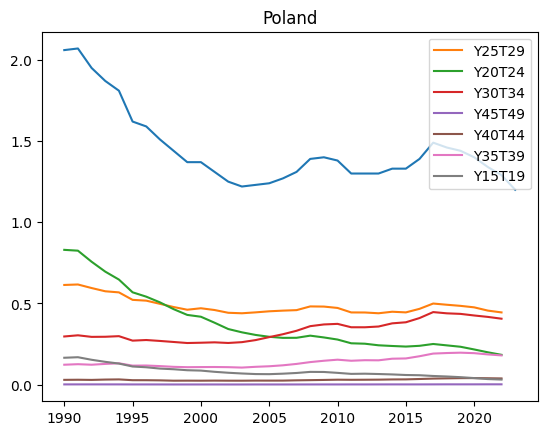

In [90]:
plot_time_series(df, "Poland", 1970, "OBS_VALUE")

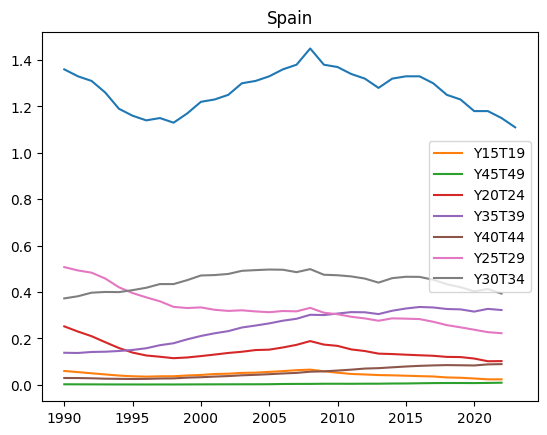

In [92]:
plot_time_series(df, "Spain", 1970, "OBS_VALUE")

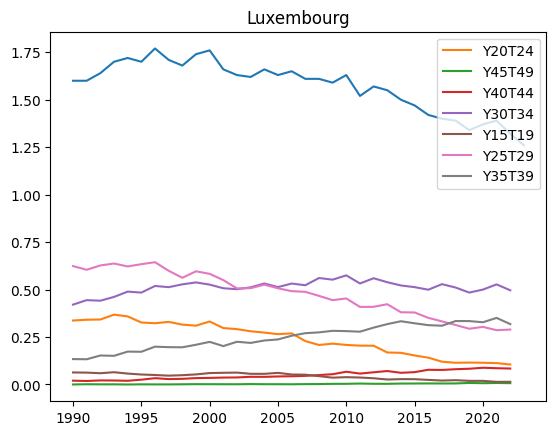

In [93]:
plot_time_series(df, "Luxembourg", 1970)

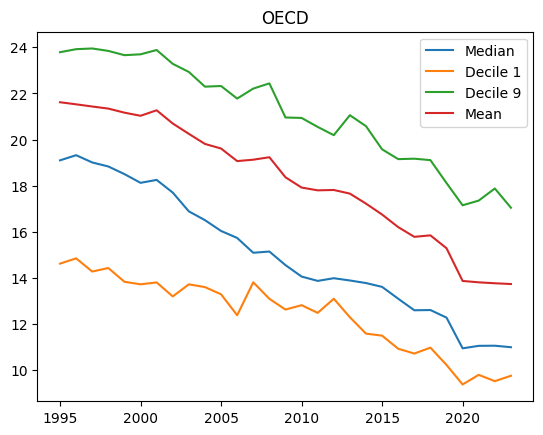

In [34]:
plot_time_series(df, "OECD", 1970)

## Generate profiling report

In [95]:
profile = ProfileReport(df, title="Fertility rate dataset")
profile.to_file(report_path)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 241.17it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Save data

In [96]:
df.to_csv(output_path, index=False)